<a href="https://colab.research.google.com/github/jdmartinev/ST1613-AppliedML-/blob/main/Semana04/Penguins_RF_and_GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación con Random Forest y Gradient Boosting

En este cuaderno aplicaremos ensambles de árboles de decisión tipo random forest y gradient boosting a un [dataset para predecir la especie de algunos pingüinos](https://www.openml.org/d/42585), usando validación cruzada para seleccionar buenos hiperparámetros.

In [54]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

In [55]:
# Definamos el "random_state" para que los resultados sean reproducibles:
random_state=42

In [56]:
# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

## Preprocesamiento de datos

In [71]:
# Descarguemos nuestro dataset desde OpenML:

dataset = fetch_openml('penguins', as_frame=False)

data = pd.DataFrame(
    dataset.data,
    columns=dataset.feature_names
)

data['species'] = dataset.target

data

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,Adelie
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,Adelie
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,Adelie
3,Torgersen,NaN,NaN,NaN,NaN,NaN,Adelie
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,Adelie
...,...,...,...,...,...,...,...
339,Biscoe,NaN,NaN,NaN,NaN,NaN,Gentoo
340,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,Gentoo
341,Biscoe,50.4,15.7,222.0,5750.0,MALE,Gentoo
342,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,Gentoo


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   island             344 non-null    object
 1   culmen_length_mm   342 non-null    object
 2   culmen_depth_mm    342 non-null    object
 3   flipper_length_mm  342 non-null    object
 4   body_mass_g        342 non-null    object
 5   sex                334 non-null    object
 6   species            344 non-null    object
dtypes: object(7)
memory usage: 18.9+ KB


In [73]:
# Hallemos el número de datos faltantes en cada columna:
data.isna().sum()

island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
species               0
dtype: int64

In [74]:
# Eliminemos las filas con datos faltantes:
data.dropna(axis=0, how='any', inplace=True)

In [75]:
# Verifiquemos que ya no haya datos faltantes en ninguna columna:
data.isna().sum()

island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
species              0
dtype: int64

In [76]:
# Analicemos la distribución de los valores de la columna `island`:
data['island'].value_counts()

island
Biscoe       164
Dream        123
Torgersen     47
Name: count, dtype: int64

In [77]:
# Analicemos la distribución de los valores de la columna `sex`:
data['sex'].value_counts()

sex
MALE      168
FEMALE    165
_           1
Name: count, dtype: int64

In [78]:
# Eliminemos la fila donde la columna `sex` es igual a 3:
data.drop(index=data[data['sex'] == 3.0].index, inplace=True)

In [47]:
# Visualicemos los datos reducidos a dos dimensiones:
'''
data.reset_index(drop=True, inplace=True)

pca = PCA(2)
z = pca.fit_transform(data.drop(columns='species'))

fig, ax = plt.subplots()
for label in data['species'].unique():
    ax.scatter(
        z[data[data['species'] == label].index, 0],
        z[data[data['species'] == label].index, 1],
        label=label
    )
ax.legend()
fig.set_size_inches(1.6*5, 5)
'''

"\ndata.reset_index(drop=True, inplace=True)\n\npca = PCA(2)\nz = pca.fit_transform(data.drop(columns='species'))\n\nfig, ax = plt.subplots()\nfor label in data['species'].unique():\n    ax.scatter(\n        z[data[data['species'] == label].index, 0],\n        z[data[data['species'] == label].index, 1],\n        label=label\n    )\nax.legend()\nfig.set_size_inches(1.6*5, 5)\n"

In [79]:
# Analicemos la distribución de los valores de la etiqueta `species`:
data['species'].value_counts()

species
Adelie       146
Gentoo       120
Chinstrap     68
Name: count, dtype: int64

In [81]:
data['culmen_length_mm'] = pd.to_numeric(data['culmen_length_mm'], errors='coerce')
data['culmen_length_mm'] = data['culmen_length_mm'].fillna(0)
data['culmen_depth_mm'] = pd.to_numeric(data['culmen_depth_mm'], errors='coerce')
data['culmen_depth_mm'] = data['culmen_depth_mm'].fillna(0)
data['flipper_length_mm'] = pd.to_numeric(data['flipper_length_mm'], errors='coerce')
data['flipper_length_mm'] = data['flipper_length_mm'].fillna(0)
data['body_mass_g'] = pd.to_numeric(data['body_mass_g'], errors='coerce')
data['body_mass_g'] = data['body_mass_g'].fillna(0)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             334 non-null    object 
 1   culmen_length_mm   334 non-null    float64
 2   culmen_depth_mm    334 non-null    float64
 3   flipper_length_mm  334 non-null    float64
 4   body_mass_g        334 non-null    float64
 5   sex                334 non-null    object 
 6   species            334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [83]:
# Separemos nuestros datos en conjuntos de entrenamiento y prueba:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns='species'),
    data['species'],
    test_size=0.2,
    stratify=data['species'],
    random_state=random_state
)

In [50]:
X_train

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
205,Dream,50.7,19.7,203.0,4050.0,MALE
164,Dream,47.0,17.3,185.0,3700.0,FEMALE
90,Dream,35.7,18.0,202.0,3550.0,FEMALE
106,Biscoe,38.6,17.2,199.0,3750.0,FEMALE
140,Dream,40.2,17.1,193.0,3400.0,FEMALE
...,...,...,...,...,...,...
24,Biscoe,38.8,17.2,180.0,3800.0,MALE
201,Dream,49.8,17.3,198.0,3675.0,FEMALE
43,Dream,44.1,19.7,196.0,4400.0,MALE
255,Biscoe,48.4,16.3,220.0,5400.0,MALE


In [84]:
#Índices de las columnas numéricas y categ+oricas
cat_cols = X_train.select_dtypes(include=object).columns
num_cols = X_train.select_dtypes(include=np.number).columns

In [85]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

In [86]:

# Defineamos los modelos base (un random forest y un gradient boosting):
rf_base = RandomForestClassifier(random_state=random_state)
gb_base = GradientBoostingClassifier(random_state=random_state)

# Definamos la malla de parámetros sobre la que haremos la búsqueda:
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': list(range(2, 8)),
    'classifier__min_samples_leaf': [1, 10, 50]
}

pipeline_rf = Pipeline(steps = [
    ('processor', preprocessor),
    ('classifier', rf_base),
                            ])

pipeline_gb = Pipeline(steps = [
    ('processor', preprocessor),
    ('classifier', gb_base),
    ])

# Definamos nuestros modelo mediante GridSearchCV:
rf = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid)
gb = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid)


In [87]:
#time
# Entrenemos el random forest:
rf.fit(X_train, y_train)
# Entrenemos el gradient boosting:
gb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['island', 'sex'], dtype='object'))])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [2, 3, 4, 5, 6, 7],
                         'classifier__min_samples_leaf': [1, 10, 50],
                         'classifier__n_estimators': [50, 100]})

In [88]:
# Obtengamos los mejores hiperparámetros encontrados para el random forest:
rf.best_params_

{'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 100}

In [89]:
# Obtengamos los mejores hiperparámetros encontrados para el gradient boosting:
gb.best_params_

{'classifier__max_depth': 2,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 100}

In [90]:
# Obtengamos la accuracy y el F1 score de entrenamiento para cada modelo:
print("Training set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'Accuracy: {model.score(X_train, y_train)}')
    print(f"F1 score: {f1_score(y_train, model.predict(X_train), average='macro')}")
    print('\n')

Training set
Model: Random Forest
Accuracy: 1.0
F1 score: 1.0


Model: Gradient Boosting
Accuracy: 1.0
F1 score: 1.0




In [91]:
# Obtengamos la accuracy y el F1 score de prueba para cada modelo:
print("Test set")
for model in (rf, gb):
    print(f"Model: {'Random Forest' if model == rf else 'Gradient Boosting'}")
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f"F1 score: {f1_score(y_test, model.predict(X_test), average='macro')}")
    print('\n')

Test set
Model: Random Forest
Accuracy: 1.0
F1 score: 1.0


Model: Gradient Boosting
Accuracy: 0.9701492537313433
F1 score: 0.9743961352657005




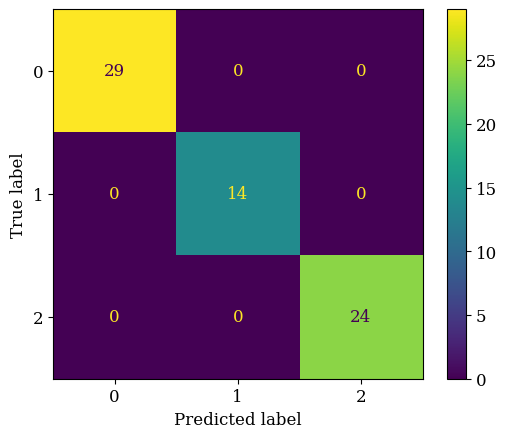

In [92]:
# Grafiquemos la matriz de confusión del random foresr para los datos de prueba (sin normalizar):
cm = confusion_matrix(y_test,rf.predict(X_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

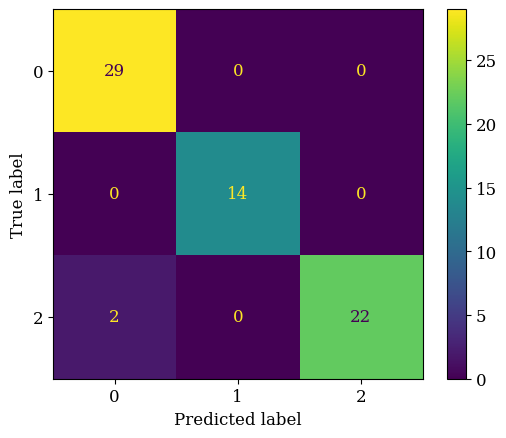

In [93]:
# Grafiquemos la matriz de confusión del gradient boosting para los datos de prueba (sin normalizar):
cm = confusion_matrix(y_test,gb.predict(X_test))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [94]:
# Veamos los datos junto con las predicciones de ambos modelos:
pd.concat([
    data.reset_index(drop=True),
    pd.DataFrame({'rf_predicted_species': rf.predict(data.drop(columns='species'))}),
    pd.DataFrame({'gb_predicted_species': gb.predict(data.drop(columns='species'))})
], axis=1)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,species,rf_predicted_species,gb_predicted_species
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,Adelie,Adelie,Adelie
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,Adelie,Adelie,Adelie
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,Adelie,Adelie,Adelie
3,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,Adelie,Adelie,Adelie
4,Torgersen,39.3,20.6,190.0,3650.0,MALE,Adelie,Adelie,Adelie
...,...,...,...,...,...,...,...,...,...
329,Biscoe,47.2,13.7,214.0,4925.0,FEMALE,Gentoo,Gentoo,Gentoo
330,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,Gentoo,Gentoo,Gentoo
331,Biscoe,50.4,15.7,222.0,5750.0,MALE,Gentoo,Gentoo,Gentoo
332,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,Gentoo,Gentoo,Gentoo
